In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy.plot import barplot, dotplot

sns.set_context("paper", font_scale=2) # set some nice global plotting settings.

from IPython.display import Image # just for embedding plots we want you to try to make without providing code :)


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Saving your processed adata

# Load processed adata

In [2]:
adata = sc.read("/data/class/cosmos_cluster6/PUBLIC/ref/example_cortex_adata_processed.h5ad")


In [3]:
adata.uns['log1p']["base"] = None # probably have to run this line, known scanpy bug.. https://github.com/scverse/scanpy/issues/2239#issuecomment-1104178881 


# Calculate cluster marker genes using scanpy

[Tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#differentially-expressed-genes-as-markers)

(You'll probably get a ton of PerformanceWarnings but they're fine to ignore, not errors just warnings about some internal scanpy code) 

In [4]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden", method="t-test")


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragme

## Dot plot of cluster markers

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


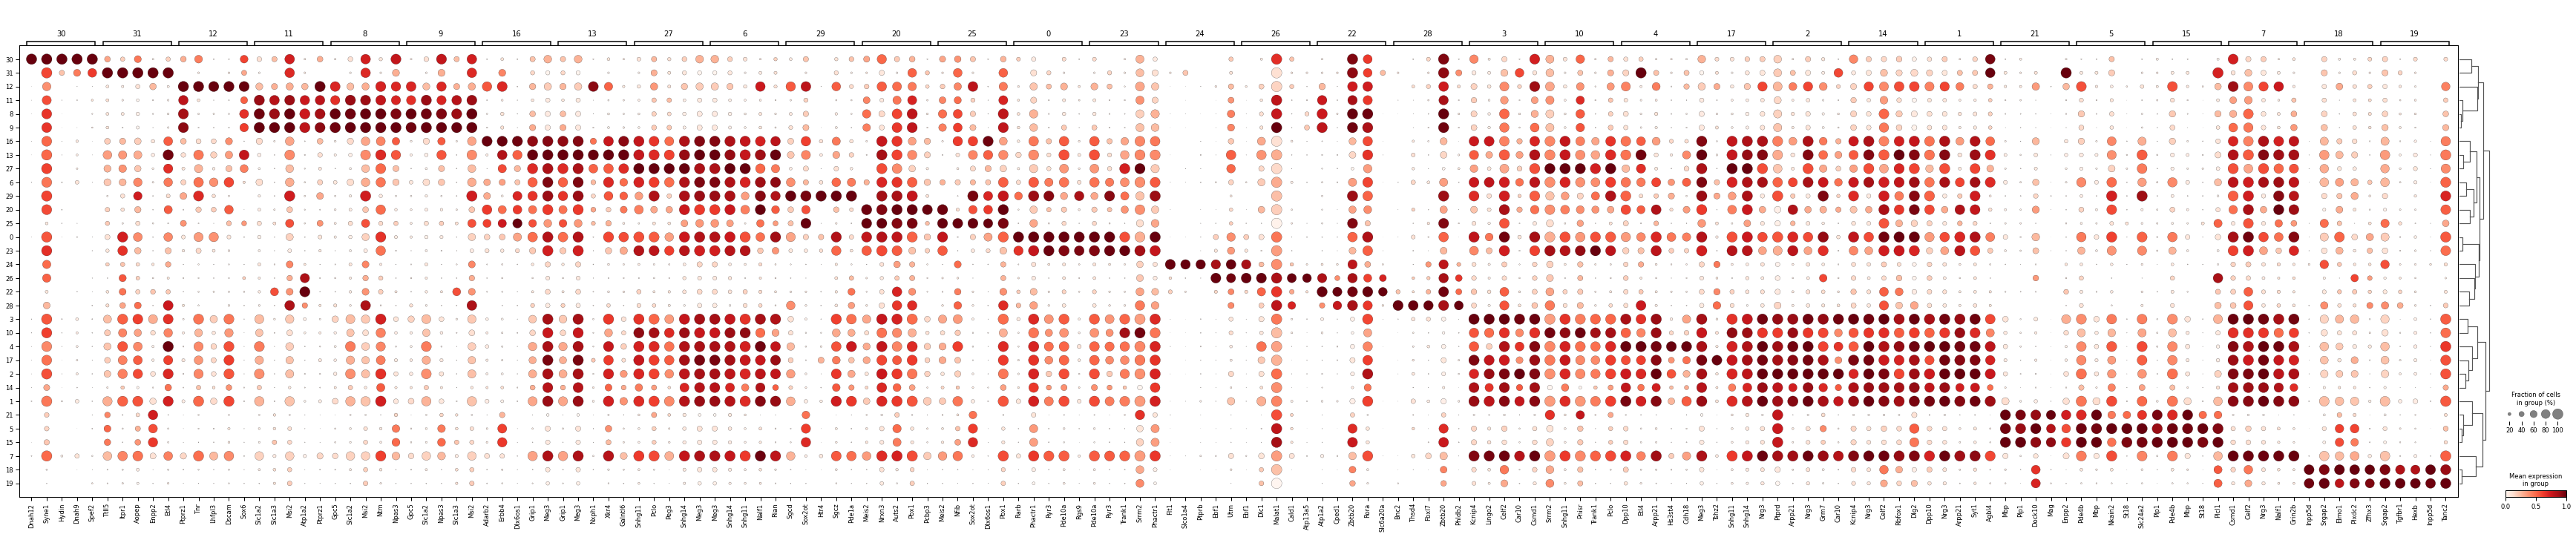

In [5]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)

## Example 1: looking further into cluster 0

### GO term analysis of cluster markers
Looking at so many genes is kind of overwhelming, sometimes GO terms help clarify what's going on!

In [6]:
markers_cluster0 = sc.get.rank_genes_groups_df(adata, group="0")


In [7]:
markers_cluster0.head()

names      scores  logfoldchanges  pvals  pvals_adj
0     Rarb  115.430519        6.088091    0.0        0.0
1  Phactr1  106.533012        3.521880    0.0        0.0
2     Ryr3  105.369125        4.221817    0.0        0.0
3   Pde10a  100.053780        3.873734    0.0        0.0
4     Rgs9   94.231339        5.896373    0.0        0.0

In [8]:
# gp.get_library_name(organism='Mouse') # available gene set libraries -- feel free to uncomment & explore others!!!


(456, 5)


<Axes: xlabel='Combined Score'>

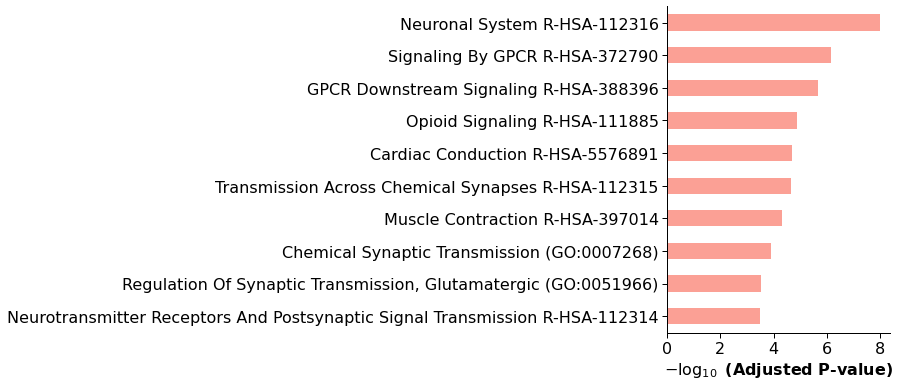

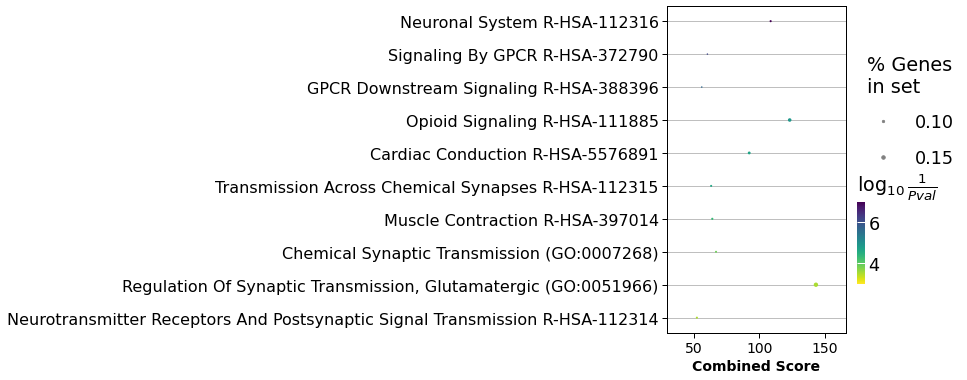

In [9]:
markers_cluster0 = markers_cluster0[(markers_cluster0['pvals_adj'] < 0.01) & (markers_cluster0['logfoldchanges'] > 2)]
print(markers_cluster0.shape) # 100-1,000 typically a good number of genes for GO analysis

# Perform Reactome Pathway Enrichment Analysis
enr_cluster0 = gp.enrichr(gene_list=markers_cluster0['names'], 
                 organism='Mouse', # change organism to your organism
                 gene_sets=['Reactome_2022','GO_Biological_Process_2023'])

# Plot results
barplot(enr_cluster0.results, cutoff=0.05)
dotplot(enr_cluster0.results, cutoff=0.05)


#### Check specific genes from GO analysis
`enr.results` has more information not shown in plots such as the genes in your list that were in each GO term / reactome pathway.

In [10]:
# can see which genes were in which reactome pathway 

enr_cluster0.results.head()



Gene_set                                    Term Overlap  \
0  Reactome_2022            Neuronal System R-HSA-112316  34/386   
1  Reactome_2022          Signaling By GPCR R-HSA-372790  43/689   
2  Reactome_2022  GPCR Downstream Signaling R-HSA-388396  39/619   
3  Reactome_2022           Opioid Signaling R-HSA-111885   13/88   
4  Reactome_2022        Cardiac Conduction R-HSA-5576891  15/126   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.861308e-11      1.059084e-08            0                     0   
1  2.538256e-09      7.221338e-07            0                     0   
2  1.124859e-08      2.133482e-06            0                     0   
3  9.629248e-08      1.369761e-05            0                     0   
4  1.893625e-07      2.154945e-05            0                     0   

   Odds Ratio  Combined Score  \
0    4.392826      108.534249   
1    3.045802       60.281878   
2    3.057951       55.969746   
3    7.617667      123.070087   
4    5.954832       92.178439   

                                               Genes  
0  GRIA1;CAMK2B;EPB41;NRXN3;KCNA4;ABAT;KIF17;GRM1...  
1  CAMK2B;PLPPR1;PDE1C;DGKB;PDE1B;ITPR1;WNT8B;HTR...  
2  CAMK2B;PDE1C;DGKB;PDE1B;ITPR1;HTR2C;GPR83;HTR4...  
3  CAMK2B;PDE1C;PDE1B;ITPR1;PDYN;ADCY5;PPP3CA;GNA...  
4  RYR1;CAMK2B;KCND2;KCNIP2;ITPR1;CACNA1C;ATP2B1;...

In [11]:
# can also see which genes were in which GO term by filtering results

enr_cluster0.results[enr_cluster0.results['Gene_set'] == 'GO_Biological_Process_2023'].head()



Gene_set  \
569  GO_Biological_Process_2023   
570  GO_Biological_Process_2023   
571  GO_Biological_Process_2023   
572  GO_Biological_Process_2023   
573  GO_Biological_Process_2023   

                                                  Term Overlap       P-value  \
569        Chemical Synaptic Transmission (GO:0007268)  23/273  8.273732e-08   
570  Regulation Of Synaptic Transmission, Glutamate...   10/55  4.017504e-07   
571  Anterograde Trans-Synaptic Signaling (GO:0098916)  18/199  7.599453e-07   
572  Modulation Of Chemical Synaptic Transmission (...  14/123  8.427545e-07   
573                   Prepulse Inhibition (GO:0060134)     4/5  1.309625e-06   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
569          0.000129            0                     0    4.099418   
570          0.000313            0                     0    9.715496   
571          0.000328            0                     0    4.396352   
572          0.000328            0                     0    5.647598   
573          0.000408            0                     0  172.946903   

     Combined Score                                              Genes  
569       66.851649  GRIA1;UNC13C;GRID2;KCND2;KCNIP2;GABRA4;GAD1;HT...  
570      143.084331  GRM5;GRM4;RELN;GRM7;LRRK2;DRD1;DRD2;DRD3;GRM1;...  
571       61.944686  GRIA1;UNC13C;KCND2;KCNIP2;GAD1;HTR1D;GAD2;HTR1...  
572       78.990646  GRIA1;GRID2;MCTP1;LRRK2;GRIK2;GRM1;BCR;SLC8A3;...  
573     2342.698929                               GRID2;DRD1;DRD2;DRD3

In [12]:
enr_cluster0.results['Genes'][0]

'GRIA1;CAMK2B;EPB41;NRXN3;KCNA4;ABAT;KIF17;GRM1;ADCY5;GRM5;LRRTM3;PRKAR2B;GNG7;KCNN3;CACNG4;KCNJ2;KCNH4;KCND2;PRKCB;ACTN2;GABRA4;NTRK3;GAD1;CACNA2D3;GAD2;KCNAB1;GABRG3;CACNB2;GNAL;LRRC7;CAMK4;KCNQ5;GNB5;KCNK2'

Heatmap-style UMAPs help show if marker expression is shared across clusters, and quickly tell you if expression is more global or specific to a small cluster

In [13]:
plt.rcParams['figure.figsize'] = (10, 8)

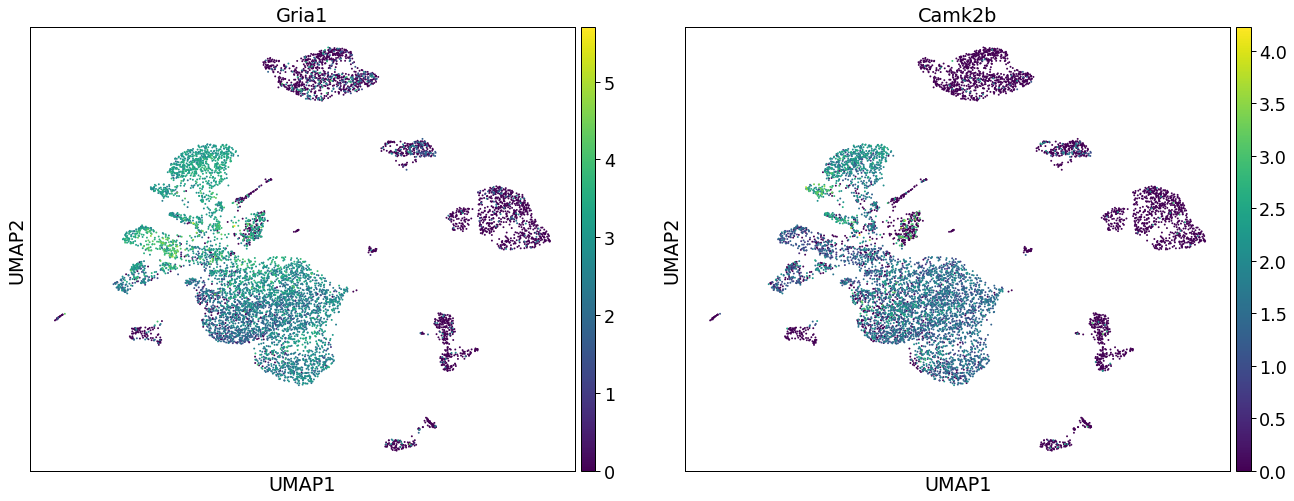

In [14]:
sc.pl.umap(adata, color=['Gria1','Camk2b'], size = 15)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


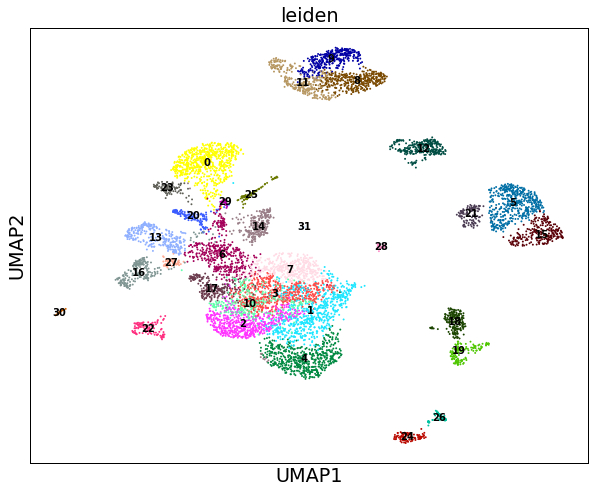

In [15]:
sc.pl.umap(adata, color=['leiden'], size = 15, legend_loc = "on data")


## Example 2: looking further into cluster 30

In [16]:
# let's try a smaller cluster
markers_cluster30 = sc.get.rank_genes_groups_df(adata, group="30")


(201, 5)


<Axes: xlabel='Combined Score'>

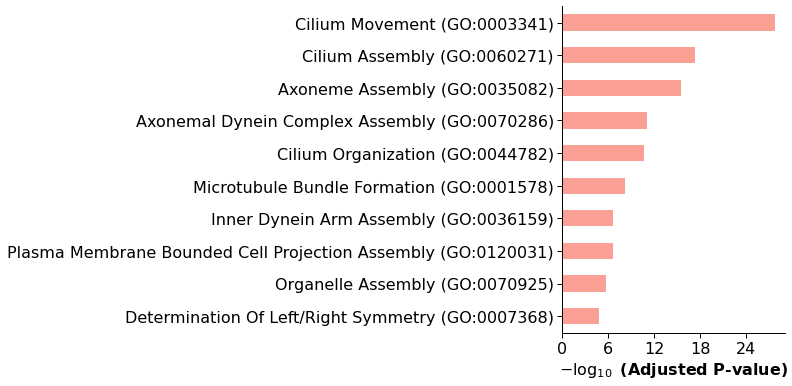

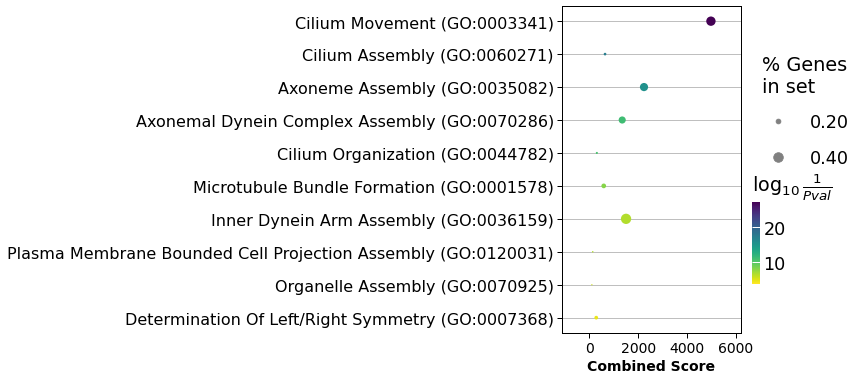

In [17]:
markers_cluster30 = markers_cluster30[(markers_cluster30['pvals_adj'] < 0.01) & (markers_cluster30['logfoldchanges'] > 2)]
print(markers_cluster30.shape) # 100-1,000 typically a good number of genes for GO analysis

# Perform Reactome Pathway Enrichment Analysis
enr_cluster30 = gp.enrichr(gene_list=markers_cluster30['names'], 
                 organism='Mouse', # change organism to your organism
                 gene_sets=['Reactome_2022','GO_Biological_Process_2023'])

# Plot results
barplot(enr_cluster30.results, cutoff=0.05)
dotplot(enr_cluster30.results, cutoff=0.05)


In [18]:
enr_cluster30.results[enr_cluster30.results['Gene_set'] == 'GO_Biological_Process_2023'].head()



Gene_set  \
166  GO_Biological_Process_2023   
167  GO_Biological_Process_2023   
168  GO_Biological_Process_2023   
169  GO_Biological_Process_2023   
170  GO_Biological_Process_2023   

                                              Term Overlap       P-value  \
166                   Cilium Movement (GO:0003341)   23/59  3.242362e-31   
167                   Cilium Assembly (GO:0060271)  27/243  1.584723e-20   
168                  Axoneme Assembly (GO:0035082)   14/41  1.883460e-18   
169  Axonemal Dynein Complex Assembly (GO:0070286)   11/37  5.457957e-14   
170               Cilium Organization (GO:0044782)  20/228  1.728716e-13   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
166      1.857873e-28            0                     0   70.934613   
167      4.540231e-18            0                     0   14.068247   
168      3.597409e-16            0                     0   54.824322   
169      7.818524e-12            0                     0   44.028947   
170      1.981109e-11            0                     0   10.407459   

     Combined Score                                              Genes  
166     4979.881930  ODAD1;DNAI4;CFAP61;SPAG17;CCDC39;DNAH1;DNAH11;...  
167      641.389566  SPAG16;SPAG17;CEP126;LRGUK;DNAH5;CDC14A;TBC1D3...  
168     2237.568126  SPAG16;DNAI4;SPAG17;CCDC39;LRGUK;CFAP74;RSPH4A...  
169     1344.605162  ODAD1;DNAI4;CCDC39;DNAH1;CFAP100;DNAH2;ODAD2;D...  
170      305.835942  CFAP61;SPAG16;CEP126;DNAH5;RFX2;TTC29;WDR35;KI...

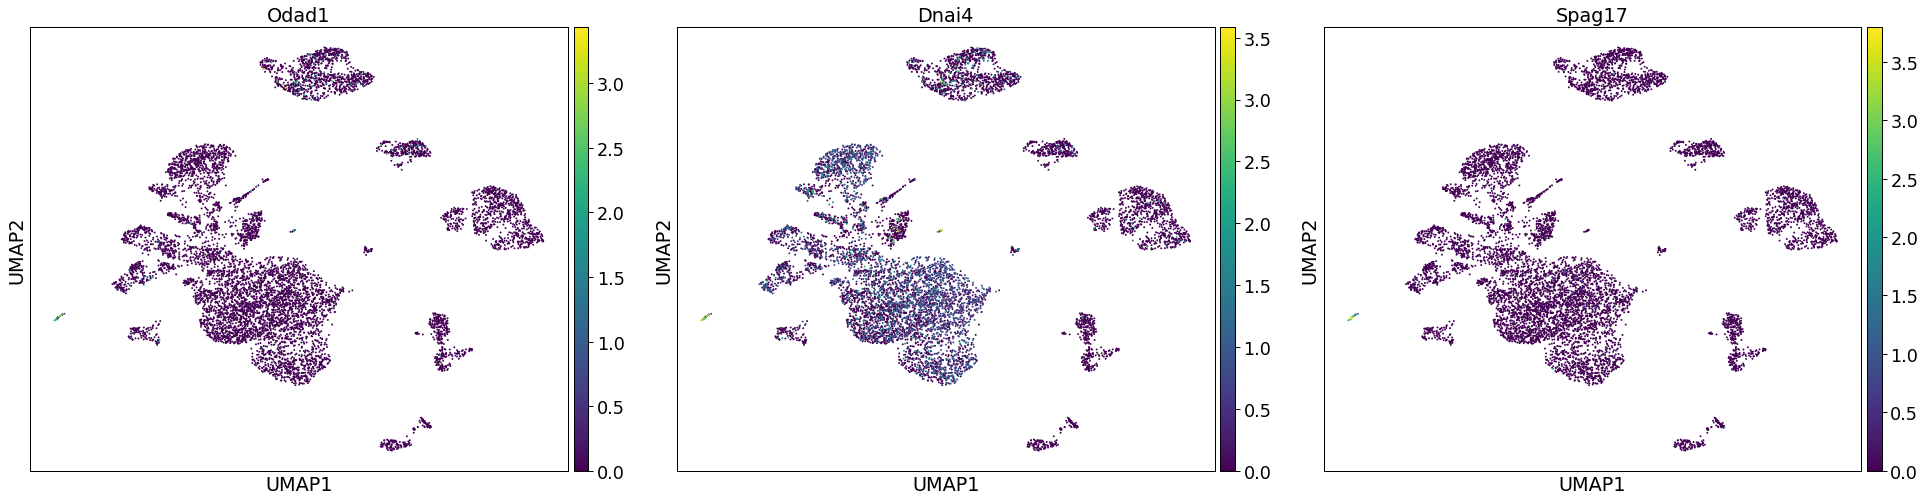

In [19]:
sc.pl.umap(adata, color=['Odad1','Dnai4','Spag17'], size = 15)

## Interpreting results

In our first example (cluster 0), some of the top-weighted GO terms had to do with neuronal systems, synaptic transmissing, etc. Since I know my data is in brain (left cerebral cortex), I can rule out the ones about heart and muscle as being super meaningful -- although of course these tissues are innervated, so those terms are still somewhat helpful! Overall, these terms tell me that the cluster 0 cell type is likely neuronal. 


Researching (Googling) marker genes is a tedious task but something that really helps in understanding your tissue and cell types! Also feel free to **ask TAs or Dr. Mortazavi** since we have spent a lot more time researching individual genes and might know something about at least one or two! :) 



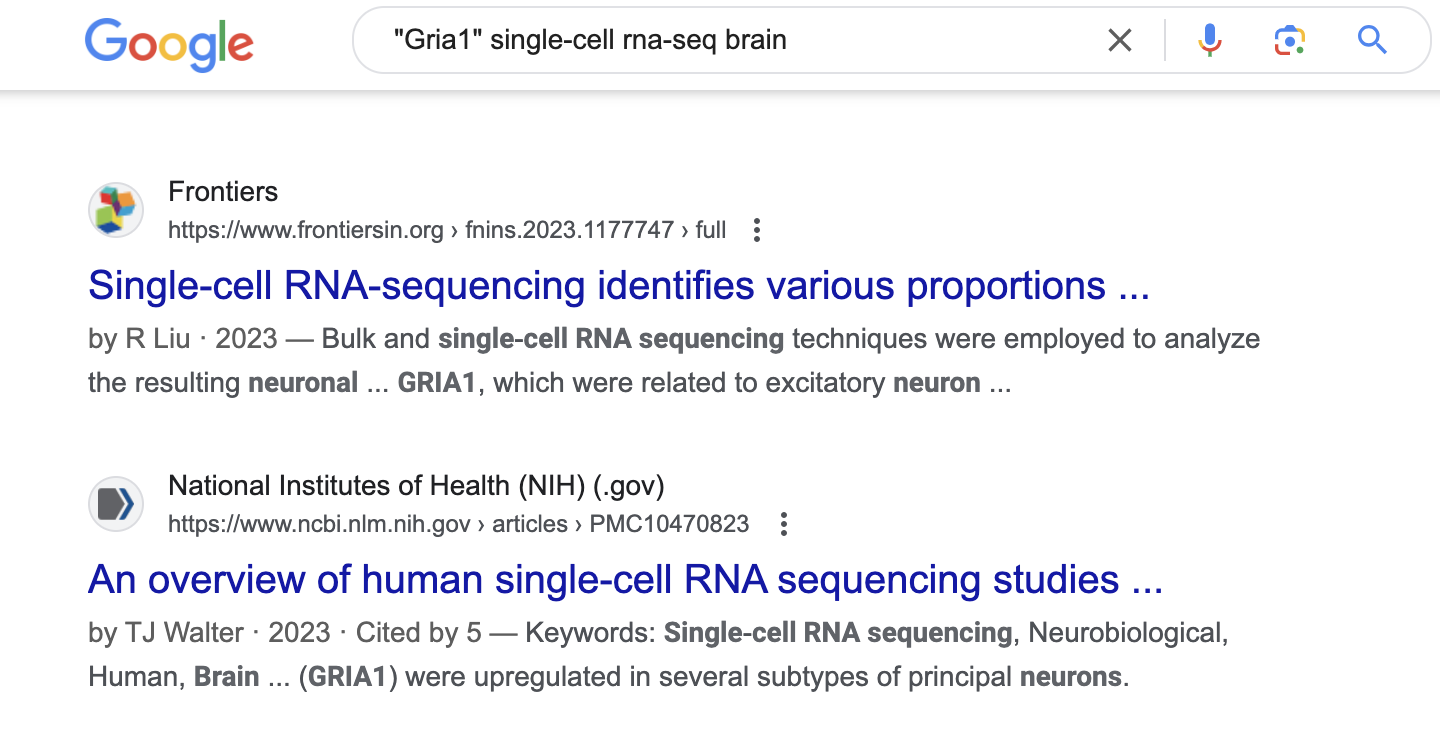

In [20]:
Image(filename='results/gria1.png')


These results from example #2 in cluster 30 are a little harder to interpret. However, Googling "cilium assembly brain cell type" had some interesting results regarding ependymal cells. In addition, other single-cell RNA-seq literature in brain also talks about some of the cluster-specific markers like Spag17. 

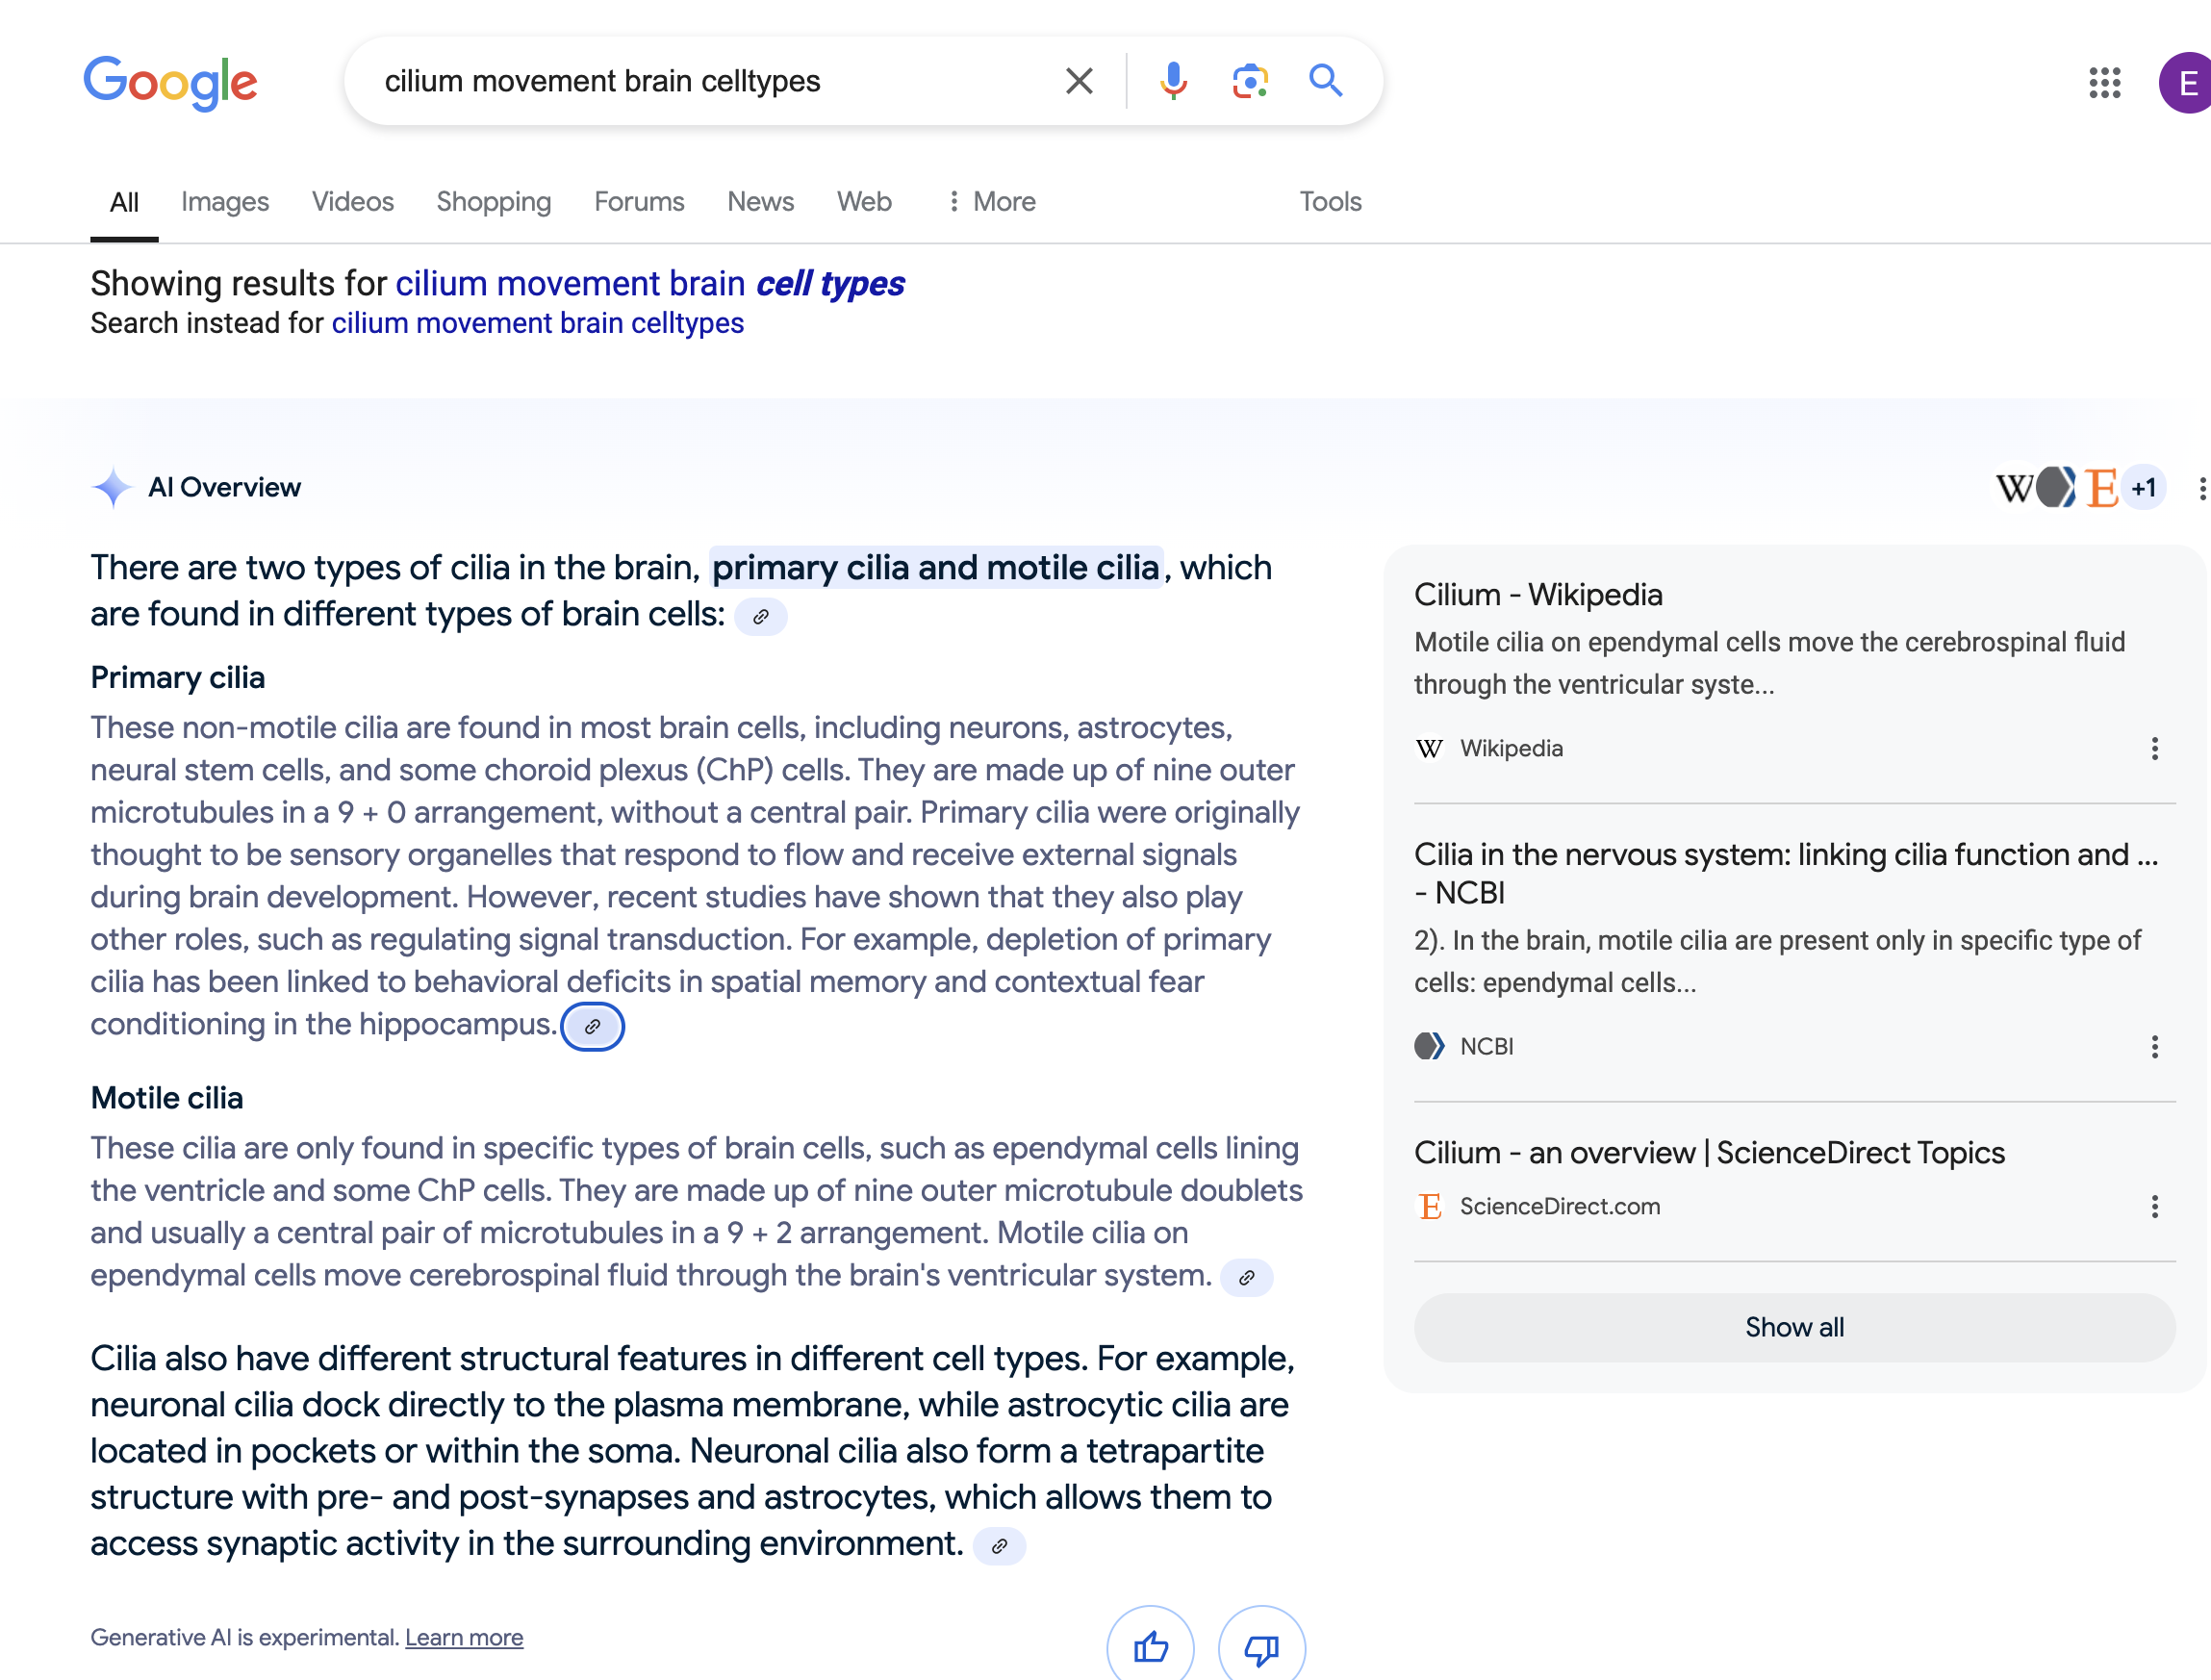

In [21]:
Image(filename='results/cilia.png')


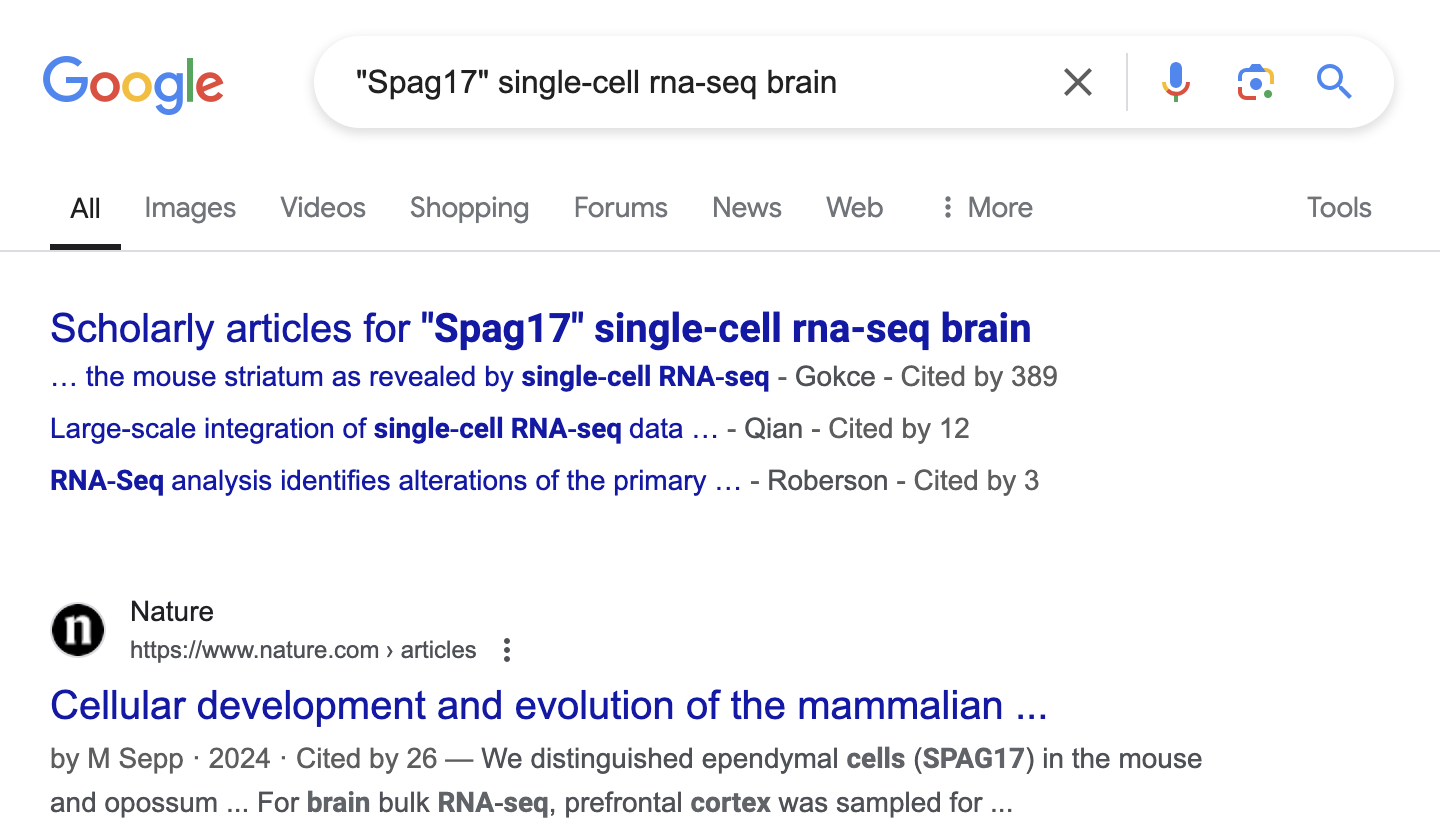

In [22]:
Image(filename='results/spag17.png')


# Post-annotation pseudobulk differential expression analysis

## Create pseudobulk matrix
This code assumes your clusters are annotated with celltypes and your adata as a celltype obs column, e.g. `adata.obs['celltype']` exists!

In [23]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col='Sample',
    groups_col='celltype',
    obs=adata.obs,
    layer='raw_counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)

In [24]:
pdata.obs.head()

Sample Experiment Genotype Notes  \
105_CASTJ_10M_21_Astrocyte  105_CASTJ_10M_21   igvf_b01    CASTJ   NaN   
106_CASTJ_10F_21_Astrocyte  106_CASTJ_10F_21   igvf_b01    CASTJ   NaN   
107_CASTJ_10M_21_Astrocyte  107_CASTJ_10M_21   igvf_b01    CASTJ   NaN   
108_CASTJ_10F_21_Astrocyte  108_CASTJ_10F_21   igvf_b01    CASTJ   NaN   
117_B6J_10M_21_Astrocyte      117_B6J_10M_21   igvf_b01      B6J   NaN   

                                Tissue Tissue_ID     Sex Replicate  \
105_CASTJ_10M_21_Astrocyte  LeftCortex        21    Male         1   
106_CASTJ_10F_21_Astrocyte  LeftCortex        21  Female         1   
107_CASTJ_10M_21_Astrocyte  LeftCortex        21    Male         2   
108_CASTJ_10F_21_Astrocyte  LeftCortex        21  Female         2   
117_B6J_10M_21_Astrocyte    LeftCortex        21    Male         1   

                                   DOB Age_weeks Age_days Body_weight_g  \
105_CASTJ_10M_21_Astrocyte  11/22/2022        10       72          20.4   
106_CASTJ_10F_21_Astrocyte  11/22/2022        10       72          24.0   
107_CASTJ_10M_21_Astrocyte  11/22/2022        10       72          21.3   
108_CASTJ_10F_21_Astrocyte  11/22/2022        10       72          24.9   
117_B6J_10M_21_Astrocyte     11/8/2022        10       72          13.2   

                           Estrus_cycle Dissection_date Dissection_time  \
105_CASTJ_10M_21_Astrocyte    Metestrus        2/2/2023        10:07 AM   
106_CASTJ_10F_21_Astrocyte          NaN        2/2/2023        10:35 AM   
107_CASTJ_10M_21_Astrocyte    Metestrus        2/2/2023        10:16 AM   
108_CASTJ_10F_21_Astrocyte          NaN        2/2/2023        10:44 AM   
117_B6J_10M_21_Astrocyte       Diestrus       1/19/2023        10:57 AM   

                           Tissue_weight_mg   celltype  psbulk_n_cells  \
105_CASTJ_10M_21_Astrocyte              138  Astrocyte            89.0   
106_CASTJ_10F_21_Astrocyte              147  Astrocyte           125.0   
107_CASTJ_10M_21_Astrocyte              156  Astrocyte           116.0   
108_CASTJ_10F_21_Astrocyte              141  Astrocyte           144.0   
117_B6J_10M_21_Astrocyte                119  Astrocyte           120.0   

                            psbulk_counts  
105_CASTJ_10M_21_Astrocyte       175039.0  
106_CASTJ_10F_21_Astrocyte       275927.0  
107_CASTJ_10M_21_Astrocyte       206644.0  
108_CASTJ_10F_21_Astrocyte       258433.0  
117_B6J_10M_21_Astrocyte         274139.0

## Compare two groups within each celltype
Save results to csv's. Takes a while to run.

In [25]:
comparison = 'Genotype' # change to your comparison of interest!
group1 = 'CASTJ' # upregulated genes will be up in this group
group2 = 'B6J' # other group for comparison

In [25]:
types = adata.obs['celltype'].unique()

for this_type in types:
    print(this_type)
    gdata = pdata[pdata.obs[comparison].isin([group1, group2])].copy() # filter for the 2 groups of interest
    ctdata = gdata[gdata.obs['celltype'] == this_type].copy()

    # Count the number of samples in each group
    group_counts = ctdata.obs[comparison].value_counts()
    
    # Make sure each group is present
    if (group_counts.get(group1, 0) >= 1) and (group_counts.get(group2, 0) >= 1):
        dds = DeseqDataSet(adata=ctdata,
                           design_factors=comparison, 
                           refit_cooks=True)
        
        dds.deseq2()
        stat_res = DeseqStats(dds, contrast=[comparison, group1, group2])
        stat_res.summary()
        
        results = stat_res.results_df # get results df
        
        results['celltype'] = this_type
        results['nlog10padj'] = -np.log10(results['padj']) # make -log10(adj. p-value) column
        results.replace([np.inf, -np.inf], np.nan, inplace=True) # remove NAN and infinity values...
        results = results.dropna() # drop NAs
        results = results.reset_index().rename(columns={'index': 'gene_name'}) # set gene name to be its own column
        results.to_csv(f'results/deg_results_{this_type}_{group1}_vs_{group2}.csv', index=False)
    else:
        print(f"Skipping {this_type} because both groups are not present.")
        

Neuron
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 21.78 seconds.

Fitting dispersion trend curve...
... done in 26.32 seconds.

Fitting MAP dispersions...
... done in 15.67 seconds.

Fitting LFCs...
... done in 4.38 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.52 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange     lfcSE      stat    pvalue  \
gene_name                                                                
0610005C13Rik   3.210471        0.362502  0.738919  0.490584  0.623721   
0610006L08Rik   0.417554        0.967909  1.805823  0.535993  0.591963   
0610009B22Rik   7.032265       -0.107681  0.540918 -0.199072  0.842207   
0610009E02Rik  45.031372        0.005866  0.149217  0.039310  0.968643   
0610009L18Rik   4.149971        0.138672  0.487919  0.284210  0.776249   
...                  ...             ...       ...       ...       ...   
mt-Ti           0.226185        1.006925  3.816373  0.263843  0.791901   
mt-Tl1          0.099974       -0.435760  3.872784 -0.112519  0.910412   
mt-Tm           0.099974       -0.435760  3.872784 -0.112519  0.910412   
mt-Tr           0.140737        1.006924  3.873269  0.259968  0.794889   
mt-Tv           0.100298       -0.435760  3.872784 -0.112519  0.910412   

                   padj  
gene_name                
0610005C13Rik  0.775332  
0610006L08Rik       NaN  
0610009B22Rik  0.917393  
0610009E02Rik  0.985624  
0610009L18Rik  0.878683  
...                 ...  
mt-Ti               NaN  
mt-Tl1              NaN  
mt-Tm               NaN  
mt-Tr               NaN  
mt-Tv               NaN  

[29897 rows x 6 columns]

/opt/apps/python/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Oligodendrocyte
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 11.45 seconds.

Fitting dispersion trend curve...
... done in 15.50 seconds.

Fitting MAP dispersions...
... done in 6.95 seconds.

Fitting LFCs...
... done in 2.50 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.50 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
gene_name                                                                  
0610005C13Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610006L08Rik  0.080965        0.116604  3.870039  0.030130  0.975964   NaN
0610009B22Rik  0.121242        1.559288  3.870118  0.402904  0.687019   NaN
0610009E02Rik  0.749481       -0.572073  1.633619 -0.350188  0.726198   NaN
0610009L18Rik  0.000000             NaN       NaN       NaN       NaN   NaN
...                 ...             ...       ...       ...       ...   ...
mt-Ti          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tl1         0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tm          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tr          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tv          0.000000             NaN       NaN       NaN       NaN   NaN

[29897 rows x 6 columns]

Endothelial
Fitting size factors...
... done in 0.00 seconds.



/opt/apps/python/3.8.0/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Fitting dispersions...
... done in 7.12 seconds.

Fitting dispersion trend curve...
... done in 10.09 seconds.

Fitting MAP dispersions...
... done in 3.41 seconds.

Fitting LFCs...
... done in 2.45 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.51 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange    lfcSE      stat    pvalue      padj
gene_name                                                                     
0610005C13Rik  0.000000             NaN      NaN       NaN       NaN       NaN
0610006L08Rik  0.000000             NaN      NaN       NaN       NaN       NaN
0610009B22Rik  0.000000             NaN      NaN       NaN       NaN       NaN
0610009E02Rik  0.246767       -1.739439  4.13126 -0.421043  0.673724  0.985011
0610009L18Rik  0.000000             NaN      NaN       NaN       NaN       NaN
...                 ...             ...      ...       ...       ...       ...
mt-Ti          0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tl1         0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tm          0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tr          0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tv          0.000000             NaN      NaN       NaN       NaN       NaN

[29897 rows x 6 columns]

Astrocyte
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 13.25 seconds.

Fitting dispersion trend curve...
... done in 17.66 seconds.

Fitting MAP dispersions...
... done in 7.95 seconds.

Fitting LFCs...
... done in 2.99 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.70 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
gene_name                                                                  
0610005C13Rik  0.147358        1.043214  3.868723  0.269653  0.787427   NaN
0610006L08Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610009B22Rik  0.345654        0.987975  2.418431  0.408519  0.682893   NaN
0610009E02Rik  1.814146        1.620366  1.100884  1.471878  0.141054   NaN
0610009L18Rik  1.007605        0.299025  1.346066  0.222147  0.824199   NaN
...                 ...             ...       ...       ...       ...   ...
mt-Ti          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tl1         0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tm          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tr          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tv          0.000000             NaN       NaN       NaN       NaN   NaN

[29897 rows x 6 columns]

Microglia
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 9.02 seconds.

Fitting dispersion trend curve...
... done in 13.11 seconds.

Fitting MAP dispersions...


/opt/apps/python/3.8.0/lib/python3.8/site-packages/pydeseq2/dds.py:558: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/opt/apps/python/3.8.0/lib/python3.8/site-packages/numpy/lib/utils.py:1119: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan


... done in 5.08 seconds.

Fitting LFCs...


/opt/apps/python/3.8.0/lib/python3.8/site-packages/pydeseq2/dds.py:623: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 2.39 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.52 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
gene_name                                                                  
0610005C13Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610006L08Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610009B22Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610009E02Rik  0.156138       -0.695461  3.798462 -0.183090  0.854727   NaN
0610009L18Rik  0.078069       -0.089200  3.875363 -0.023017  0.981637   NaN
...                 ...             ...       ...       ...       ...   ...
mt-Ti          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tl1         0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tm          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tr          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tv          0.000000             NaN       NaN       NaN       NaN   NaN

[29897 rows x 6 columns]

OPC
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 10.56 seconds.

Fitting dispersion trend curve...
... done in 14.59 seconds.

Fitting MAP dispersions...
... done in 6.21 seconds.

Fitting LFCs...
... done in 2.59 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.72 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
gene_name                                                                  
0610005C13Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610006L08Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610009B22Rik  0.483216        1.390946  2.229641  0.623843  0.532731   NaN
0610009E02Rik  0.000000             NaN       NaN       NaN       NaN   NaN
0610009L18Rik  0.234838        0.189070  3.051911  0.061951  0.950602   NaN
...                 ...             ...       ...       ...       ...   ...
mt-Ti          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tl1         0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tm          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tr          0.000000             NaN       NaN       NaN       NaN   NaN
mt-Tv          0.000000             NaN       NaN       NaN       NaN   NaN

[29897 rows x 6 columns]

VLMC
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 8.02 seconds.

Fitting dispersion trend curve...
... done in 11.33 seconds.

Fitting MAP dispersions...
... done in 3.78 seconds.

Fitting LFCs...
... done in 2.35 seconds.

Refitting 0 outliers.

Running Wald tests...
... done in 4.51 seconds.

Log2 fold change & Wald test p-value: Genotype CASTJ vs B6J


baseMean  log2FoldChange    lfcSE      stat    pvalue      padj
gene_name                                                                     
0610005C13Rik  0.000000             NaN      NaN       NaN       NaN       NaN
0610006L08Rik  0.000000             NaN      NaN       NaN       NaN       NaN
0610009B22Rik  0.000000             NaN      NaN       NaN       NaN       NaN
0610009E02Rik  0.133707       -0.694583  4.42567 -0.156944  0.875289  0.984037
0610009L18Rik  0.000000             NaN      NaN       NaN       NaN       NaN
...                 ...             ...      ...       ...       ...       ...
mt-Ti          0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tl1         0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tm          0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tr          0.000000             NaN      NaN       NaN       NaN       NaN
mt-Tv          0.000000             NaN      NaN       NaN       NaN       NaN

[29897 rows x 6 columns]

Pericyte
Skipping Pericyte because both groups are not present.
Epithelial
Skipping Epithelial because both groups are not present.
Fibroblast
Skipping Fibroblast because both groups are not present.
Ependymal
Skipping Ependymal because both groups are not present.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/apps/python/3.8.0/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Dot plot of DEGs

In [26]:
fname = "Oligodendrocyte_CASTJ_vs_B6J" # example!! change for your file!
results = pd.read_csv(f"results/deg_results_{fname}.csv")


In [27]:
# at celltype level -- maybe not too interesting

In [28]:
degs_up = results[(results['padj'] < 0.05) & (results['log2FoldChange'] > 2)] # increased lfc threshold for less genes to show
degs_down = results[(results['padj'] < 0.05) & (results['log2FoldChange'] < -2)] 



/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


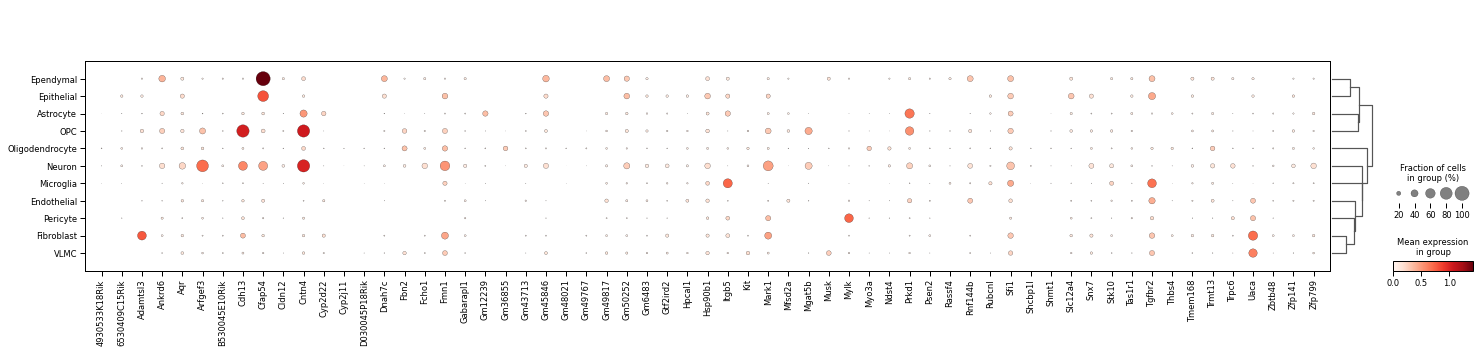

In [29]:
sc.pl.dotplot(adata, degs_up['gene_name'].tolist(), 'celltype', 
              mean_only_expressed = False,
              dendrogram=True, log=True)



/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


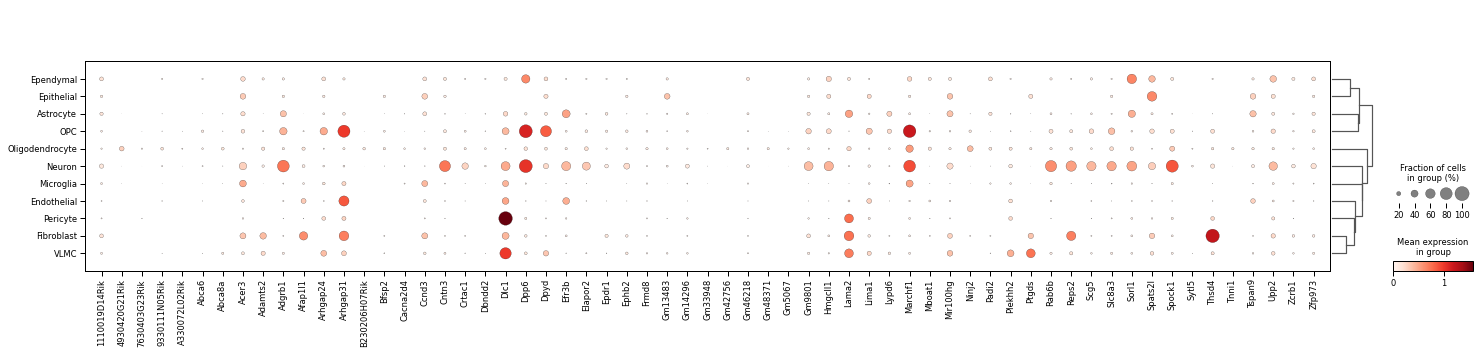

In [30]:
sc.pl.dotplot(adata, degs_down['gene_name'].tolist(), 'celltype', 
              mean_only_expressed = False,
              dendrogram=True, log=True)



In [31]:
# try filtering the adata for the celltype of interest and grouping by comparison


In [32]:
adata_thistype = adata[adata.obs['celltype'] == 'Oligodendrocyte'].copy()

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


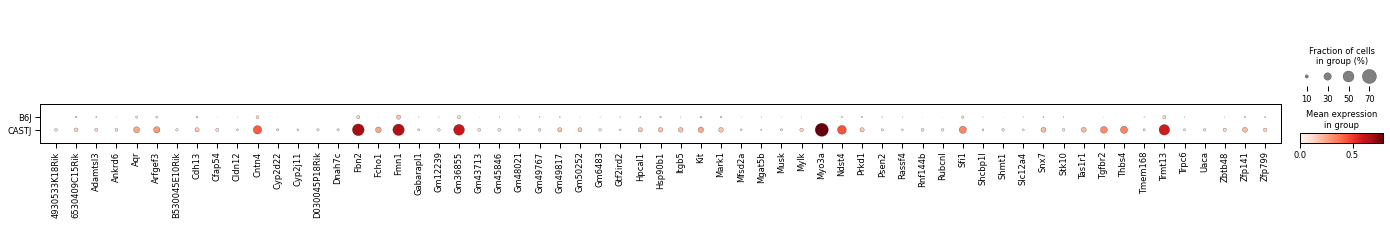

In [33]:
sc.pl.dotplot(adata_thistype, degs_up['gene_name'].tolist(), 'Genotype', 
              mean_only_expressed = False,
              dendrogram=True, log=True)


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


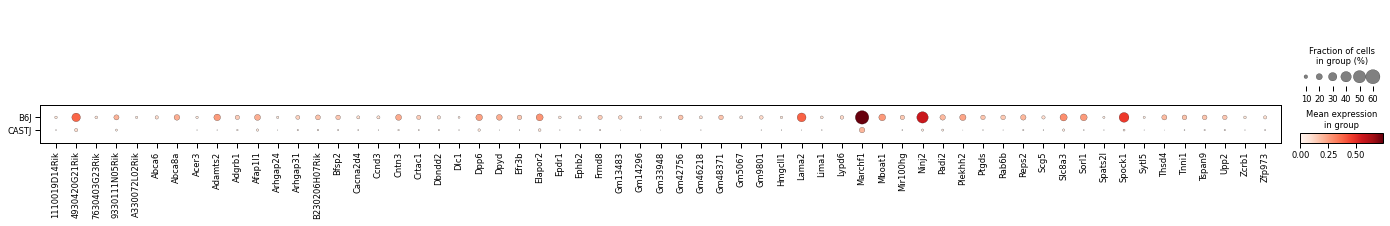

In [34]:
sc.pl.dotplot(adata_thistype, degs_down['gene_name'].tolist(), 'Genotype', 
              mean_only_expressed = False,
              dendrogram=True, log=True)


## Volcano plot

In [35]:
! pip install adjustText # in case u dont have this package

from adjustText import adjust_text

/opt/apps/python/3.8.0/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
Defaulting to user installation because normal site-packages is not writeable


In [36]:
fname = "Oligodendrocyte_CASTJ_vs_B6J" # example!! change for your file!
results = pd.read_csv(f"results/deg_results_{fname}.csv")


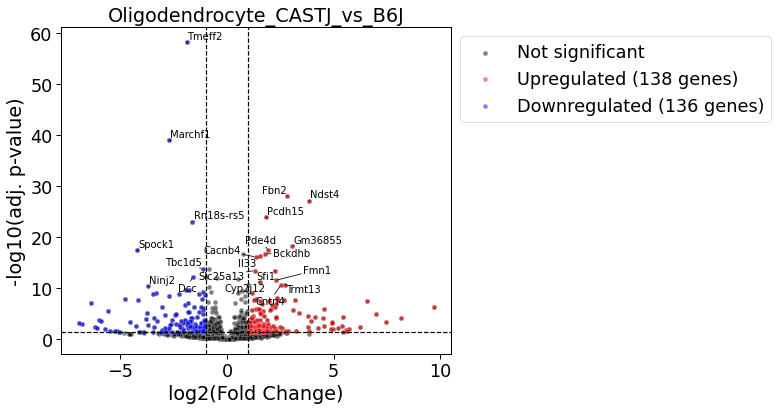

In [37]:
degs_up = results[(results['padj'] < 0.05) & (results['log2FoldChange'] > 1)]
degs_down = results[(results['padj'] < 0.05) & (results['log2FoldChange'] < -1)]


plt.figure(figsize=(7, 6))
sns.scatterplot(data=results, x='log2FoldChange', y='nlog10padj', alpha=0.5, 
                color='black', label = "Not significant")

# basically layer the subset dataframes on top of the original plot
sns.scatterplot(data=degs_up, x='log2FoldChange', y='nlog10padj', alpha=0.5, 
                color='red', label = f"Upregulated ({len(degs_up)} genes)")
sns.scatterplot(data=degs_down, x='log2FoldChange', y='nlog10padj', alpha=0.5, 
                color='blue', label = f"Downregulated ({len(degs_down)} genes)")

plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(adj. p-value)')
plt.title(fname)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # move legend

# draw horizontal and vertical dashed lines
plt.axhline(1.3, color='black', linestyle='--')
plt.axvline(1, color='black', linestyle='--')
plt.axvline(-1, color='black', linestyle='--')

# sry this should help fix the overlaps
texts = []
for index, row in results.iterrows():
    if abs(row['log2FoldChange']) > 1 and row['nlog10padj'] > 10:
        texts.append(plt.text(row['log2FoldChange'], row['nlog10padj'], row['gene_name'], fontsize=10))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

plt.show()


## GO term enrichment of DEGs

Up- and down-regulated **separately**

<Axes: xlabel='Combined Score'>

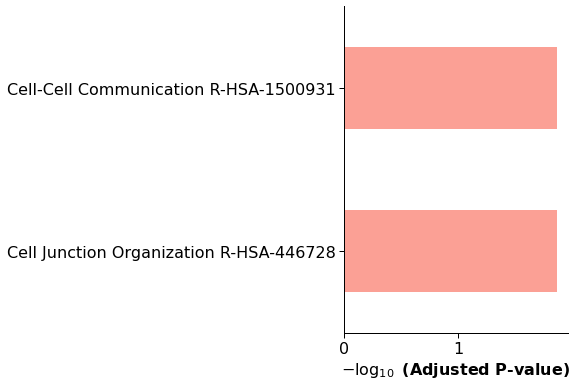

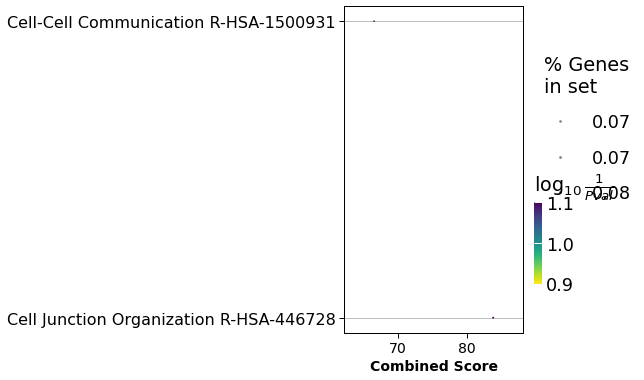

In [38]:
degs_up = results[(results['padj'] < 0.05) & (results['log2FoldChange'] > 0.2)] # not many DEGs in my case so had to decrease LFC threshold...

enr_up = gp.enrichr(gene_list=degs_up['gene_name'], 
                 organism='Mouse', # change organism to your organism
                 gene_sets=['Reactome_2022','GO_Biological_Process_2023'])

barplot(enr_up.results, cutoff=0.05)
dotplot(enr_up.results, cutoff=0.05)

<Axes: xlabel='Combined Score'>

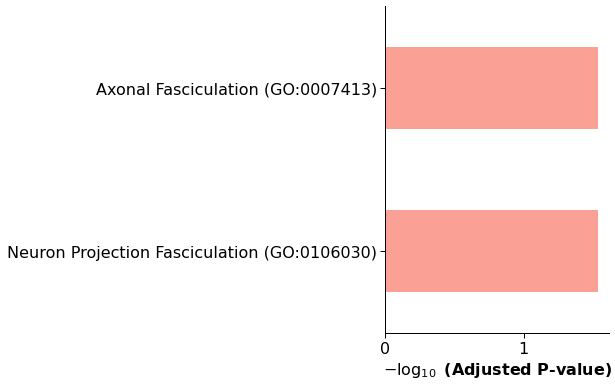

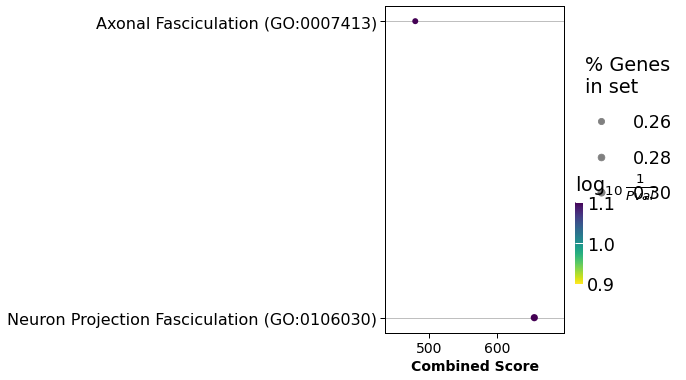

In [39]:
degs_down = results[(results['padj'] < 0.05) & (results['log2FoldChange'] < -1)]

enr_down = gp.enrichr(gene_list=degs_down['gene_name'], 
                 organism='Mouse', # change organism to your organism
                 gene_sets=['Reactome_2022','GO_Biological_Process_2023'])

barplot(enr_down.results, cutoff=0.05)
dotplot(enr_down.results, cutoff=0.05)